In [71]:
# This jupyter notebooks shows how density fluctuations of an ultracold quantum gas can be recovered from absorption imaging data.
# The derivations for the used formulas can be found in the corresponding Bachelor Thesis.

In [72]:
from EvaluationHelpers import extractVariableNames
from EvaluationHelpers import extractVariableValuesFromSingleString
from EvaluationHelpers import createImageInfoList
from EvaluationHelpers import aggregateRunsByVariable
from EvaluationHelpers import makeDensityImage
from EvaluationHelpers import loadImageRemoveDark

import scipy.constants as const
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import os



### Parameters

In [109]:
# parameters of the imaging system
pixel_side_length = 16e-6   # in meter
pixel_size =  (pixel_side_length)**2   # pixel size on camera in m^2 
magnification = 16  # magnification of the lens system

A = (1.09739368998628e-6)**2 # pixel size in atom plane that is magnified on one camera pixel

gain = 1   # camera gain

readout_noise = 7

wl_laser = 671e-9   # laser wavelength
sigma_factor = 1
sigma_zero = 3*(wl_laser**2)/(2*np.pi)
sigma_eff = sigma_factor * sigma_zero  # effective cross section of photon absorption

counts_sat_rate = 56.0   # counts per microsecond at one saturation intensity
meas_duration = 5        # in us

counts_sat = counts_sat_rate * meas_duration   # number of detected photons during exposure time at one saturation intensity  

(1.09739368998628e-6)**2

1.2042729108217036e-12

### Functions

In [110]:
def circ_ring(r, image_sizes, ring_position):
    '''
    This function creates an image (2D numpy array) of a ring with radius r 
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image sizes in x/y direction
        ring_position: tuple (pos_x, pos_y), coordinates of the center of the ring (the point (0,0) is in the top left corner)
    Output:
        - ring mask (2D numpy array) with ones/True in the ring and zeros/False outside of the ring
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = ring_position
    
    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)

    # Mask 1 is the inverse of a circle with radius r
    # Mask 2 is a circle with radius r+1
    mask1 = (r_x-pos_x)**2 + (r_y-pos_y)**2 >= r**2 
    mask2 = (r_x-pos_x)**2 + (r_y-pos_y)**2 < (r + 1)**2 

    return mask2*mask1 # the overlap of the two masks is a ring 

In [111]:
def radial_average(image, averaging_midpoint):
    '''
    This function takes an image (2D numpy array) and calculates its radial average (1D numpy array). 
    For plotting one should use the return on the y-axis and radial_axis on the x-axis. 
    This function does not control if a radius lies partially outside of the image
    Input:
        image:
        averaging_midpoint: tuple (midpoint_x, midpoint_y), that determines the central point of the radial average (the point (0,0) is in the top left corner)
    Output:
        radial_axis: x-axis to plot the radial_average using e.g. matplotlib.pyplot.plot()
        radial_average:
    '''

    image_sizes = (np.shape(image))[::-1]  # tuple (image_size_x, image_size_y)

    radial_axis = np.arange(0, image_sizes[0]//2)
    radial_sum = np.zeros(image_sizes[0]//2)
    radial_N = np.zeros(image_sizes[0]//2)

    for r in radial_axis:

    
        radial_sum[r] = np.sum(image * circ_ring(r, image_sizes, averaging_midpoint))  # summed signal at radius r
        radial_N[r] = np.sum(circ_ring(r, image_sizes, averaging_midpoint))   # Number of pixels at radius r

    radial_average = radial_sum/radial_N

    return radial_axis, radial_average

In [112]:
def circ_mask(r, image_sizes, circle_position):
    '''
    This function creates an image (2D numpy array) of a circle with radius r
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image_sizes in number of pixels
        circle_position: tuple (pos_x, pos_y)  of the center coordinate of the circle (the point (0,0) is in the top left corner )
    Output:
        - circular mask with ones/True in the circle and zeros/False outside of the circle
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = circle_position
    
    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)       # r_x, r_y assign to each pixel its x, y coordinate

    
    mask = (r_x - pos_x)**2 + (r_y - pos_y)**2 <= r**2    # the circle equation is used here

    return mask 

### Creating the InfoList (grabbing the filenames)

In [113]:
# current_dir = os.getcwd()     # grab current directory
# print(current_dir)

In [114]:
# tuned variables in the dataset 
variable_names = ["i"]


In [115]:
# Detecting the files in the dataset

infoList = createImageInfoList(["Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750"], variable_names)
print(infoList[0]) 

{'i': 1.0, 'atoms': 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\AtomsM_i_1.png', 'reference': 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\BrightM_i_1.png', 'atom_background': 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\AtomsDarkM_i_1.png', 'ref_background': 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\BrightDarkM_i_1.png'}


In [116]:
# this sorts the data by the different Micro_2_Z_set 
newInfoList = aggregateRunsByVariable("i", infoList)
print(newInfoList[0]["files"][0])


# only one of the different Micro_2_Z_set positions in the dataset is needed for this demonstration:
InfoList_crop = newInfoList[0]

['Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\AtomsM_i_1.png', 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\BrightM_i_1.png', 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\AtomsDarkM_i_1.png', 'Z:/Archiv/2D/Experiment/2025/20250226/Images20250226/B-inSitu_hot_imaging_750\\BrightDarkM_i_1.png']


### Loading the data

In [117]:
# the Atoms and Bright images are loaded individually
atoms_list = []
bright_list = []


for image_set in InfoList_crop["files"]:
    atoms_image = loadImageRemoveDark(image_set[0], image_set[2])     # loads atoms/bright image and removes the corresponding dark image 
    bright_image = loadImageRemoveDark(image_set[1], image_set[3])

    atoms_list.append(atoms_image)
    bright_list.append(bright_image)

InfoList_crop["atoms"] = atoms_list
InfoList_crop["bright"] = bright_list


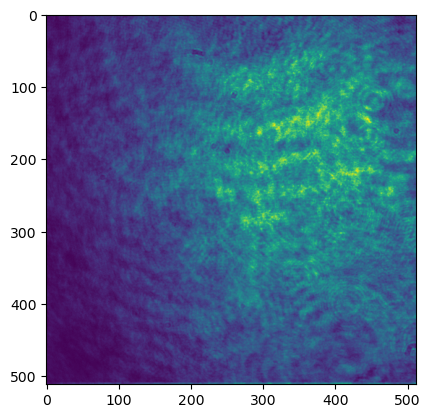

In [118]:
plt.imshow(InfoList_crop["atoms"][18])  # a single reference image

### Cropping the images

In [119]:
image_size_y = 180
image_size_x = 180

radial_axis = np.arange(image_size_x//2)

y_offset = 70
x_offset = 110 -40


sample_size = len(InfoList_crop["files"])  # number of images in sample


In [120]:
atoms_cut_list = []
bright_cut_list = []

for j in range(sample_size):
    atoms_cut = InfoList_crop["atoms"][j][y_offset:y_offset + image_size_y].T[x_offset:x_offset + image_size_x].T
    atoms_cut_list.append(atoms_cut)

    bright_cut = InfoList_crop["bright"][j][y_offset:y_offset + image_size_y].T[x_offset:x_offset + image_size_x].T
    bright_cut_list.append(bright_cut)

InfoList_crop["atoms_cut"] = atoms_cut_list
InfoList_crop["bright_cut"] = bright_cut_list


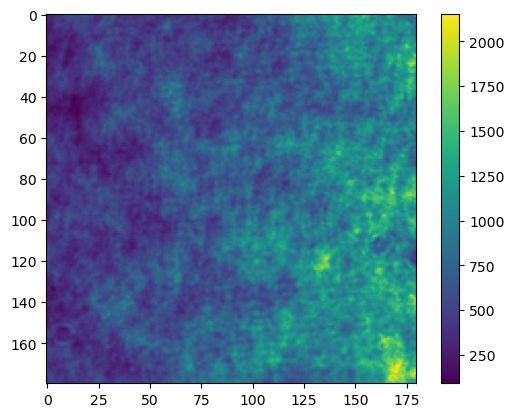

In [121]:
plt.imshow(InfoList_crop["atoms_cut"][18])
plt.colorbar()


### Adding the densities

In [122]:
# Here the high intensity absorption imaging formula (Equation 2.1 in the thesis) is applied to calculate the densities of the sample 
density_list = []

for j in range(sample_size):
    density_image = A*(- np.log(InfoList_crop["atoms_cut"][j]/InfoList_crop["bright_cut"][j]) 
                     + (InfoList_crop["bright_cut"][j] - InfoList_crop["atoms_cut"][j])/counts_sat)/sigma_eff

    density_list.append(density_image)

InfoList_crop["densities"] = density_list

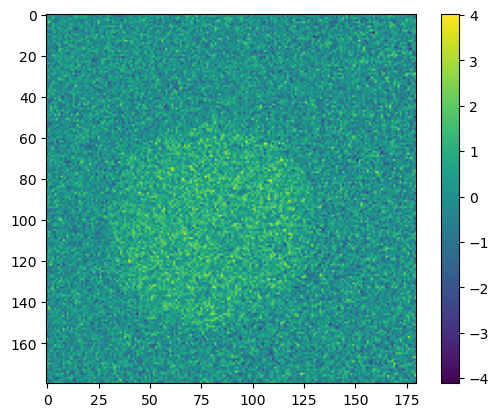

In [123]:
# example of a single density image
plt.imshow(InfoList_crop["densities"][18])
plt.colorbar()
plt.show()

### Making means and variances

In [124]:
# Here, the means and variances of the density, atoms and bright images are taken across the sample
# These quantities are important to determine the density fluctuations
InfoList_crop["mean_dens"] = np.mean(InfoList_crop["densities"], axis = 0)
InfoList_crop["mean_abs"] = np.mean(InfoList_crop["atoms_cut"], axis = 0)
InfoList_crop["mean_ref"] = np.mean(InfoList_crop["bright_cut"], axis = 0)

InfoList_crop["variance_dens"] = np.abs(np.std(InfoList_crop["densities"], axis = 0))**2
InfoList_crop["variance_abs"] = np.abs(np.std(InfoList_crop["atoms_cut"], axis = 0))**2
InfoList_crop["variance_ref"] = np.abs(np.std(InfoList_crop["bright_cut"], axis = 0))**2

In [133]:
InfoList_crop["photon_sn_abs"] = InfoList_crop["mean_abs"] #+ readout_noise**2   # variance from photon shot noise on atom images
InfoList_crop["photon_sn_ref"] = InfoList_crop["mean_ref"] #+ readout_noise**2   # variance from photon shot noise on bright images 

# fringe correction term (Equation 3.17 in the thesis)
InfoList_crop["fringe_variance"] = InfoList_crop["variance_ref"] - gain* InfoList_crop["photon_sn_ref"]

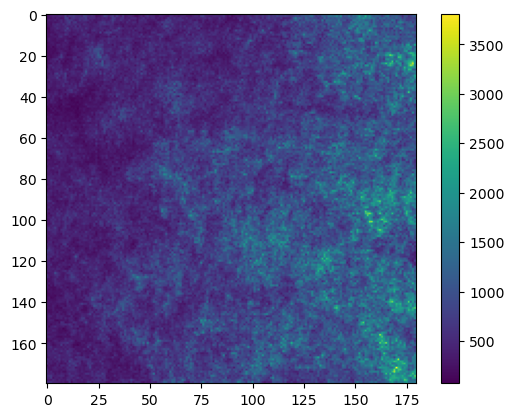

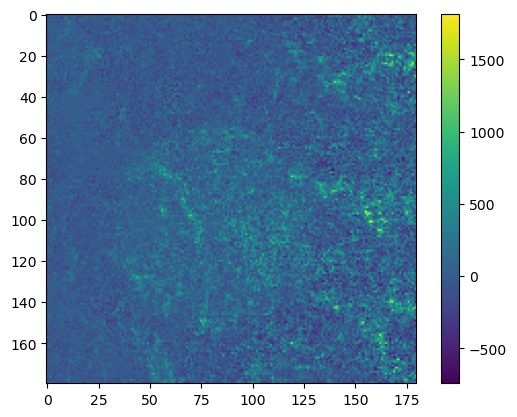

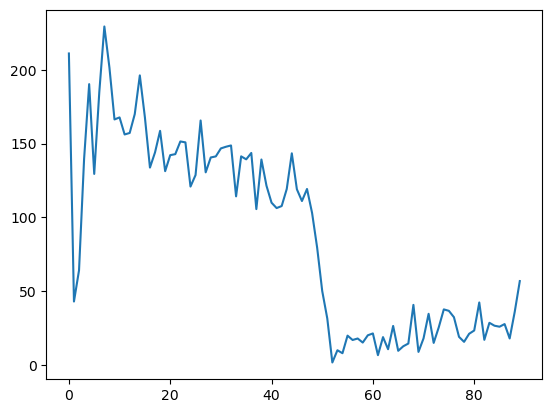

In [126]:
plt.imshow(InfoList_crop["variance_abs"])
plt.colorbar()
plt.show()

plt.imshow(InfoList_crop["variance_abs"] - InfoList_crop["photon_sn_abs"])
plt.colorbar()
plt.show()

a = radial_average(InfoList_crop["variance_abs"] - InfoList_crop["photon_sn_abs"], (81, 105))
plt.plot(a[0], a[1])


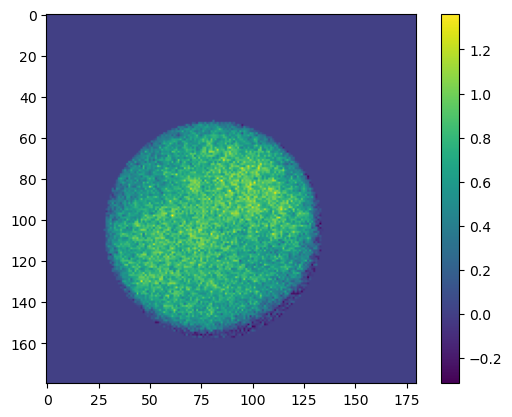

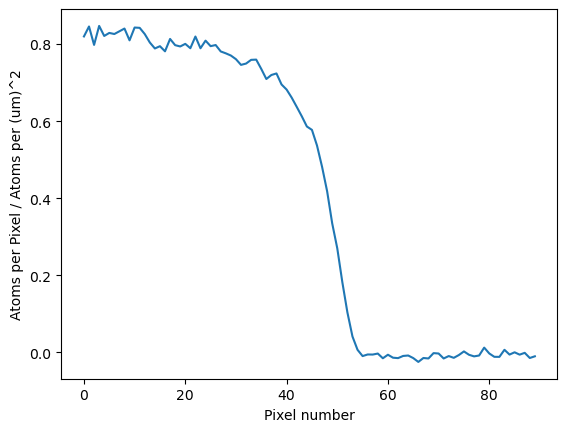

In [127]:
# plotting the mean density image and it's radial average

plot_axis = np.arange(len(InfoList_crop["mean_dens"][0]))


plt.imshow(InfoList_crop["mean_dens"]*circ_mask(53, (180,180),(81,105)))
plt.colorbar()
plt.show()
test = radial_average(InfoList_crop["mean_dens"], (81, 105))
plt.plot(test[0], test[1])
plt.xlabel("Pixel number")
plt.ylabel("Atoms per Pixel / Atoms per (um)^2")
plt.show()


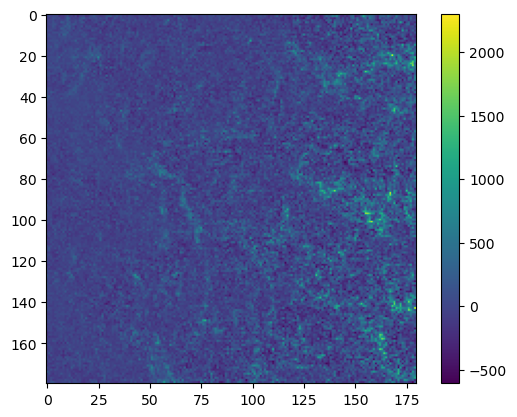

In [128]:
plt.imshow(InfoList_crop["fringe_variance"])
plt.colorbar()

### Delta N Extraction

In [129]:
# Here equation 3.16 from the thesis is applied, to calculate the density fluctuations


InfoList_crop["density_fluctuations"] = (((A/sigma_eff) * (1/InfoList_crop["mean_abs"] + 1/counts_sat))**2 *
                                           (InfoList_crop["variance_abs"] - gain * InfoList_crop["photon_sn_abs"] - InfoList_crop["fringe_variance"]))

### Plotting 

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
C:\Users\artako\AppData\Local\Temp\ipykernel_31600\3907488077.py:13: SyntaxWarning: invalid escape sequence '\m'
  labels = ["$n$ [$\mu m^{-2}$]", "$\\delta n^2$ [$\mu m^{-4}$]"]
C:\Users\artako\AppData\Local\Temp\ipykernel_31600\3907488077.py:13: SyntaxWarning: invalid escape sequence '\m'
  labels = ["$n$ [$\mu m^{-2}$]", "$\\delta n^2$ [$\mu m^{-4}$]"]
C:\Users\artako\AppData\Local\Temp\ipykernel_31600\3907488077.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("$n$ [$\mu m^{-2}$]", fontsize=14, color = colores[i])
C:\Users\artako\AppData\Local\Temp\ipykernel_31600

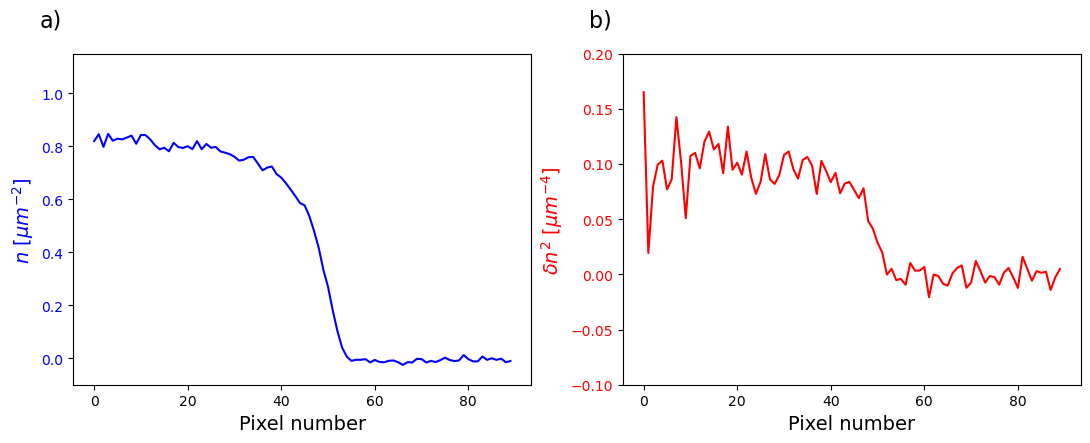

In [130]:
# these results are discussed in the thesis (see Figure 3.4)



fluctuations = [radial_average(InfoList_crop["mean_dens"], (81, 105))[1], radial_average(InfoList_crop["density_fluctuations"], (81, 105))[1]]



alphabet = ["a)", "b)"]
fig = plt.figure(figsize=(13, 4.3))
gs = gridspec.GridSpec(1, 2)
colores = ["blue", "red"]
labels = ["$n$ [$\mu m^{-2}$]", "$\\delta n^2$ [$\mu m^{-4}$]"]
y_lim = [(-0.1,1.15),(-0.1, 0.2)]

for i, g in enumerate(gs):

    ax = plt.subplot(g)
    ax.plot(radial_axis, fluctuations[i], color = colores[i])
    ax.set_xlabel("Pixel number",fontsize=14)
    plt.ylim(y_lim[i])
    ax.text(-0.05, 1.1, alphabet[i], color="black", fontsize=16, ha='center', va='center', transform=ax.transAxes)
    ax.tick_params(axis ='y', labelcolor = colores[i])
    if i == 0:
        ax.set_ylabel("$n$ [$\mu m^{-2}$]", fontsize=14, color = colores[i])
    else:
        ax.set_ylabel("$\\delta n^2$ [$\mu m^{-4}$]", fontsize=14, color=colores[i])



plt.savefig("fluctuations_real_data_130nK.pdf", format = "pdf")
plt.show()

In [131]:
print(np.mean(radial_average(InfoList_crop["density_fluctuations"], (81, 105))[1][0:40]))
print(np.mean(radial_average(InfoList_crop["density_fluctuations"], (81, 105))[1][60:]))

0.09831406502010112
-0.0014275312829612038
